In [1]:
%load_ext autoreload
%autoreload 2

In [288]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow
import seaborn as sns
from sklearn.metrics import r2_score

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

from utils import *

In [209]:
# 1D example of several GPs constrained to overlap at 1 or more points
# setting=1: 2 GPs constrained to cross at xp
# setting=2: 3 GPs constrained to cross at xp, the first is treated as the "trunk" branch
# setting=3: 2 GPs constrained to overlap at all points UP TO xp
def bgp_kernel_1d(x, xp, setting, ax):
    num_data = x.size
    x = x[:, np.newaxis]
    kernel = gpflow.kernels.SquaredExponential(lengthscales=[1.0])
    xp = np.array([[xp]])
    Kff = kernel(x)
    
    if setting == 1 or setting == 2:
        kx = kernel(x, xp)
        Kfg = kx @ tf.transpose(kx)
    elif setting == 3:
        xs = x[(x <= xp).flatten()]
        Kxu = kernel(x, xs)
        Kuu = kernel(xs)
        jitter_mtx = 1e-6 * np.eye(xs.size)
        L = tf.linalg.cholesky(Kuu + jitter_mtx)
        tmp = tf.linalg.triangular_solve(L, tf.transpose(Kxu))
        Kfg = tf.transpose(tmp) @ tmp

    if setting == 1 or setting == 3:
        tmp1 = tf.concat([Kff, Kfg], axis=0)
        tmp2 = tf.concat([Kfg, Kff], axis=0)
        Sigma = tf.concat([tmp1, tmp2], axis=1)
        y = np.random.default_rng().multivariate_normal(np.zeros(num_data * 2), Sigma)
        fx = y[:num_data]
        gx = y[num_data:]
        ax.plot(x, fx)
        ax.plot(x, gx)
    elif setting == 2:
        tmp1 = tf.concat([Kff, Kfg, Kfg], axis=0)
        tmp2 = tf.concat([Kfg, Kff, Kfg], axis=0)
        tmp3 = tf.concat([Kfg, Kfg, Kff], axis=0)
        Sigma = tf.concat([tmp1, tmp2, tmp3], axis=1)
        y = np.random.default_rng().multivariate_normal(np.zeros(num_data * 3), Sigma)
        fx = y[:num_data]
        gx = y[num_data:num_data*2]
        hx = y[num_data*2:]
        mask1 = (x <= xp).flatten()
        mask2 = (x >= xp).flatten()
        ax.plot(x[mask1], fx[mask1])
        ax.plot(x[mask2], gx[mask2])
        ax.plot(x[mask2], hx[mask2])

    ax.vlines(x=xp, ymin=y.min(), ymax=y.max(), label='constrained point', color='r')
    ax.legend()
    
    if setting == 1 or setting == 3:
        return (fx, gx)
    elif setting == 2:
        return (fx, gx, hx)

Text(0.5, 1.0, 'Extension')

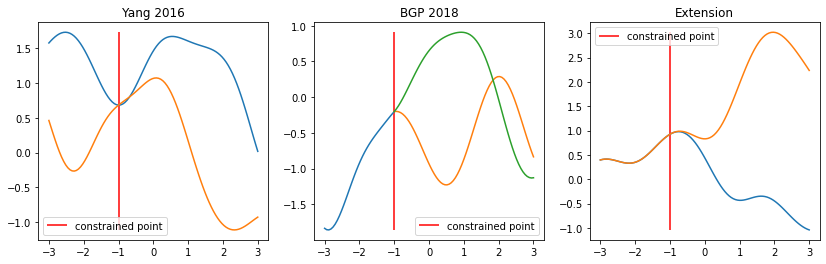

In [402]:
num_data = 100
x = np.linspace(-3, 3, num_data)
xp = -1

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
_, _ = bgp_kernel_1d(x, xp, 1, axs[0])
_, _, _ = bgp_kernel_1d(x, xp, 2, axs[1])
_, _ = bgp_kernel_1d(x, xp, 3, axs[2])
axs[0].set_title('Yang 2016')
axs[1].set_title('BGP 2018')
axs[2].set_title('Extension')

In [357]:
# generalized the bgp kernel in the following ways:
# 1. all points before branch point xp are constrained to be the same for the 2 GPs
# 2. X is [N, D] D >= 1, and Y is [N, dim], dim >= 1
# 3. Allow constraining based on only the first dimension of X
#   i.e. f(x) = g(x) for all x where x[0] < xp[0]
def bgp_kernel(X, xp, dim, x1_only=True):
    num_data = X.shape[0]
    kernel = gpflow.kernels.SquaredExponential(lengthscales=[1.0])
    Kff = kernel(X)
    if x1_only:
        mask = (X < xp)[:, 0]
    else:
        mask = np.all(X < xp, axis=1)
    Xs = X[mask, :]
    Kxu = kernel(X, Xs)
    Kuu = kernel(Xs)
    jitter_mtx = 1e-6 * np.eye(Xs.shape[0])
    L = tf.linalg.cholesky(Kuu + jitter_mtx)
    tmp = tf.linalg.triangular_solve(L, tf.transpose(Kxu))
    Kfg = tf.transpose(tmp) @ tmp

    tmp1 = tf.concat([Kff, Kfg], axis=0)
    tmp2 = tf.concat([Kfg, Kff], axis=0)
    Sigma = tf.concat([tmp1, tmp2], axis=1)

    y = np.random.default_rng().multivariate_normal(np.zeros(num_data * 2), Sigma, dim).T
    fx = y[:num_data]
    gx = y[num_data:]
    
    return (fx, gx)

In [391]:
# d is the dimension of y to plot, 1 is the first dimension
# note this plot only makes sense when we constrain only on x1
def plot_fgx(X, xp, fx, gx, d):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    assert d >= 1, 'first dimension of y is 1'
    for i in range(2):
        axs[i].scatter(X[:, i], fx[:, d-1], marker='.', label='f')
        axs[i].scatter(X[:, i], gx[:, d-1], marker='.', label='g')
        axs[i].set_xlabel('x{}'.format(i+1))
        axs[i].set_ylabel('y{}'.format(d))
        axs[i].vlines(x=xp[i], ymin=fx.min(), ymax=fx.max(), color='r', label='xb')
        axs[i].legend()

In [392]:
num_data = 30
x = np.linspace(-3, 3, num_data)
x1, x2 = np.meshgrid(x, x)
X = np.stack([x1.flatten(), x2.flatten()], axis=1)
xp = np.array([-1, 0])
dim = 2

Constrain on both dimensions

In [393]:
fx1, gx1 = bgp_kernel(X, xp, dim, x1_only=False)

Text(0.5, 0, 'y2')

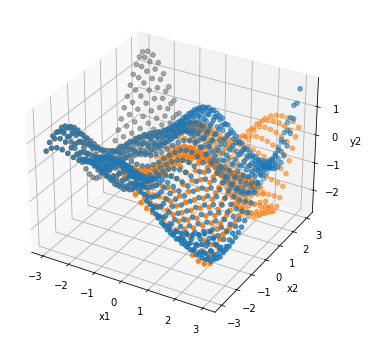

In [394]:
fig = plt.figure(figsize=(8, 6))
d = 1
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], fx[:, d-1])
ax.scatter(X[:, 0], X[:, 1], gx[:, d-1])
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y2')

Text(0.5, 0, 'y2')

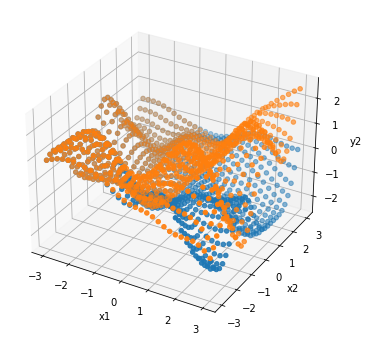

In [395]:
fig = plt.figure(figsize=(8, 6))
d = 2
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], fx[:, d-1])
ax.scatter(X[:, 0], X[:, 1], gx[:, d-1])
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y2')

Constrain only on x1

In [399]:
fx, gx = bgp_kernel(X, xp, dim, x1_only=True)

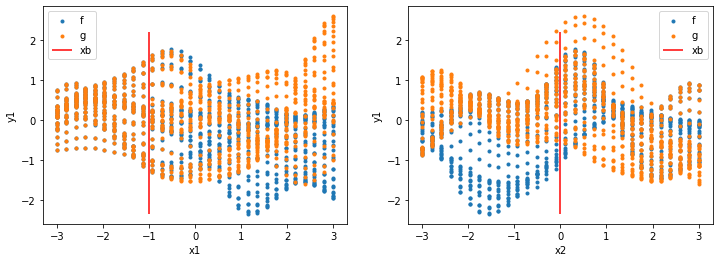

In [400]:
plot_fgx(X, xp, fx, gx, 1)

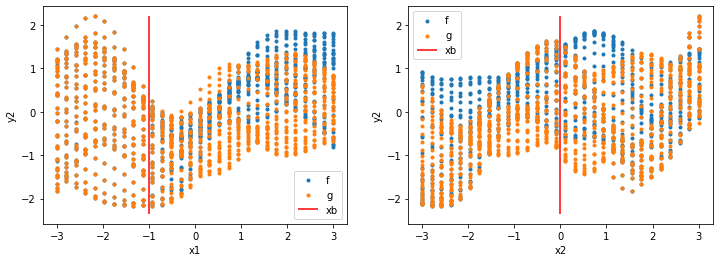

In [401]:
plot_fgx(X, xp, fx, gx, 2)